# Digits

In this notebook we are going to train a neural network to recognize handwritten digits. This is the  "Hello World" of deep learning: training a deep learning model to correctly classify hand-written digits.

In the previous [notebook](TheMNISTDataSet.ipynb) we downloaded the MNIST dataset, which is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.  We will re-use this data (downloaded either to your local hard drive or /transfer) to train a neural network to recognize the digits.

We will start by importing the necessary libraries, including our Utils module. 

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F

sys.path.append("../")
import Utils

print(f"{Utils.in_lab()=}")

Utils.in_lab()=False


## GPU Support

In this notebook we will use the GPU to train our model, we can use the function from our Utils module to check if the GPU is available and set this as the device to use for our data. 

In [2]:
device = Utils.get_device()
print(device)

mps


## Image classification

The approach we are going to take with this example is to load a set of know images and their labels, and train a neural network to learn the relationship between the images and their labels. 

We will use a neural network and a trial and error system to begin to recognize the patterns in the images. The images are small (28x28 pixels) and the neural network will learn to recognize the patterns in the images that are associated with the digits.

We have a set of 60,000 images to train the network and a separate set of 10,000 images to test the network and on each step of the training process we will check the accuracy of the network on the test set.

In the previous notebook we created two functions for loading the data and labels so we will use these functions to load the data and labels for the training and test sets.

In [4]:
def load_mnist_labels(filename: str) -> np.ndarray:
    with open(filename, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        if len(labels) != num:
            raise ValueError(f"Expected {num} labels, but got {len(labels)}")
    return labels

def load_mnist_images(filename: str) -> np.ndarray:
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        if len(images) != num:
            raise ValueError(f"Expected {num} images, but got {len(images)}")
    return images


In [5]:
DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/MNIST/"
else:
    DATASET_LOCATION = "./MNIST/"

train_labels = load_mnist_labels(DATASET_LOCATION + "train-labels-idx1-ubyte")
test_labels = load_mnist_labels(DATASET_LOCATION + "t10k-labels-idx1-ubyte")

print(len(train_labels), len(test_labels))
print(train_labels[0], test_labels[0])

# We can now load the images from both the datasets.
train_images = load_mnist_images(DATASET_LOCATION + "train-images-idx3-ubyte")
test_images = load_mnist_images(DATASET_LOCATION + "t10k-images-idx3-ubyte")

60000 10000
5 7


To see the images we can define a simple function to display the images. We will use the matplotlib library to display the images.

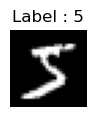

<class 'numpy.ndarray'>
(28, 28)
uint8


In [13]:
def display_image(image: np.array, label: str) -> None:
    plt.figure(figsize=(1, 1))
    plt.title(f"Label : {label}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()


# We can now display the first image from the training dataset.

display_image(train_images[0], train_labels[0])
print(type(train_images[0]))
print(train_images[0].shape)
print(train_images[0].dtype)

If we look at the data it is stored in a numpy array of 28,28 and a single unsigned char data type. We need to transform this data into the correct type for machine learning. In particular we need to convert the data into a Tensor of type float32, then we need to batch the data into a DataLoader.

We can use the torchvision library to transform our data as follows.

In [21]:

trans = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
tensor=trans(train_images[0])
print(tensor.shape)
print(tensor.dtype)
print(tensor.min(), tensor.max())
print(tensor.device)

torch.Size([1, 28, 28])
torch.float32
tensor(0.) tensor(1.)
cpu


By default the data for this tensor is processed on the CPU, we can convert 